# Test 5 & 6: Cholesky for increasing problem size

These test capture the runtime for the Cholesky decomposition with GPRat on the CPU and GPU.
We use an increasing problem size in $\{2^6, \dots, 2^{16}\}$, an fixed number of tiles of XY for CPU and XY for GPU, a fixed number of cores of $48$, 8 regressors, an fixed number of CUDA streams of XY, and loop 11 times (first loop is ignored of warmup).
Note that we do not account for the time it takes to return the data to the callee.

Findings:

- ...

In [2]:
# setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import utils

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams.update({"font.size": 11})
mpl.rcParams.update({"errorbar.capsize": 5})
mpl.rcParams.update({"grid.linewidth": 0.5})

In [3]:
# load data

apex_dir_cholesky = "./data/5/"
apex_dir_steps = "./data/6/"
subdirs = [
    "apex-cpu/",
    "apex-gpu/"
]

names_cholesky = [
    "cholesky"
]

names_steps = [
    "cholesky_step assembly",
    "cholesky_step cholesky",
    "assemble K_tiles",
    "cholesky potrf",
    "cholesky trsm",
    "cholesky syrk",
    "cholesky gemm",
]

file_headers_cpu = ["n_cores", "n_train", "n_tiles", "n_reg", "n_loops"]

file_headers_gpu = [
    "n_cores",
    "n_train",
    "n_tiles",
    "n_reg",
    "n_streams",
    "n_loops"
]

def apex_files_to_df(dir, names, file_headers):
    data = []
    for filename in os.listdir(dir):
        if filename.endswith(".csv"):
            parts = filename.replace("apex_profiles_", "").replace(".csv", "").split("_")
            file_params = dict(zip(file_headers, map(int, parts)))
            file_path = os.path.join(dir, filename)
            df = pd.read_csv(file_path)
            df = df[df['name'].isin(names)]
            for key, value in file_params.items():
                df[key] = value
            data.append(df)
    df_combined = pd.concat(data, ignore_index=True)
    df_combined = df_combined.sort_values(by="n_train")
    return df_combined

df_cholesky = []
df_steps = []
df_cholesky.append(
    apex_files_to_df(apex_dir_cholesky + subdirs[0], names_cholesky, file_headers_cpu)
)
df_cholesky.append(
    apex_files_to_df(apex_dir_cholesky + subdirs[1], names_cholesky, file_headers_gpu)
)
df_steps.append(apex_files_to_df(apex_dir_steps + subdirs[0], names_steps, file_headers_cpu))
df_steps.append(apex_files_to_df(apex_dir_steps + subdirs[1], names_steps, file_headers_gpu))

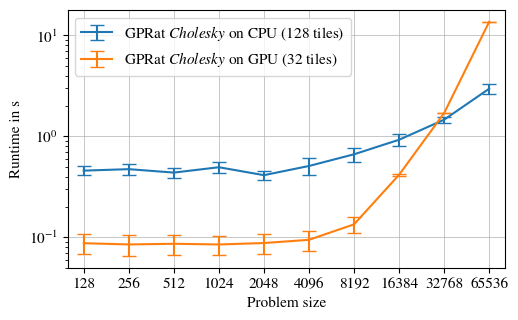

In [4]:
# plot for cholesky

n_train = 32768

plt.figure(figsize=(5, 3))

plt.xlabel('Problem size')
plt.ylabel('Runtime in s')
plt.grid(True, which="both")
plt.grid(False, which="minor")
plt.xscale('log', base=2)
plt.yscale("log", base=10)
plt.xlim(100, 83000)

xticks = df_cholesky[0]['n_train'].unique()
plt.xticks(
    xticks,
    [f"{int(nt)}" for nt in xticks],
)

labels = [
    r"GPRat $\it{Cholesky}$ on CPU",
    r"GPRat $\it{Cholesky}$ on GPU",
]
for label, df_name_target in zip(labels,df_cholesky):
    for n_tiles in df_name_target["n_tiles"].unique():
        df_name_target_n_tiles = df_name_target[df_name_target["n_tiles"] == n_tiles]
        err = utils.confidence_error(df_name_target_n_tiles, 0.95)
        plt.errorbar(
            df_name_target_n_tiles["n_train"],
            df_name_target_n_tiles["mean"] / 10**9,
            yerr=err / 10**9,
            label=label + " (" + str(n_tiles) + " tiles)",
        )

plt.legend()
plt.tight_layout(pad=0)
plt.savefig("./pdf/cholesky-cpu-gpu.pdf")

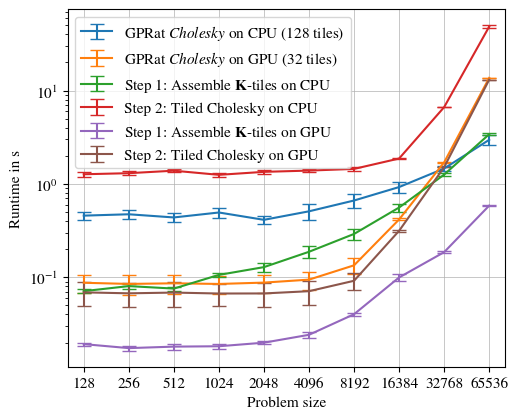

In [5]:
# plot for cholesky steps

plt.figure(figsize=(5, 4))

plt.xlabel("Problem size")
plt.ylabel("Runtime in s")
plt.grid(True, which="both")
plt.grid(False, which="minor")
plt.xscale("log", base=2)
plt.yscale("log", base=10)
plt.xlim(100, 83000)

xticks = df_cholesky[0]["n_train"].unique()
plt.xticks(
    xticks,
    [f"{int(nt)}" for nt in xticks],
)

labels = [
    r"GPRat $\it{Cholesky}$ on CPU (128 tiles)",
    r"GPRat $\it{Cholesky}$ on GPU (32 tiles)",
]
for label, df_name_target in zip(labels, df_cholesky):
    err = utils.confidence_error(df_name_target, 0.95)
    plt.errorbar(
        df_name_target["n_train"],
        df_name_target["mean"] / 10**9,
        yerr=err / 10**9,
        label=label,
    )

names = [
    "cholesky_step assembly",
    "cholesky_step cholesky",
]
labels = [
    r"Step 1: Assemble $\mathbf{K}$-tiles",
    "Step 2: Tiled Cholesky",
]
for group, target in zip(df_steps, ["CPU", "GPU"]):
    for name, label in zip(names, labels):
        df_name_target = group[group["name"] == name]
        err = utils.confidence_error(df_name_target, 0.95)
        plt.errorbar(
            df_name_target["n_train"],
            df_name_target["mean"] / 10**9,
            yerr=err / 10**9,
            label=label + " on " + target,
        )

plt.legend()
plt.tight_layout(pad=0)

plt.savefig("./pdf/cholesky-cpu-gpu-steps.pdf")

In [ ]:
# plot for cholesky BLAS

# plt.savefig("./pdf/cholesky-cpu-gpu-blas.pdf")